In [1]:
class Content: #set it for wikipedia page#

    def __init__(self, topic, url, title, body):
        self.topic = topic
        self.title = title
        self.body = body
        self.url = url

    def print(self):
        print('New article found for topic: {}'.format(self.topic))
        print('URL: {}'.format(self.url))
        print('TITLE: {}'.format(self.title))
        print('BODY:\n{}'.format(self.body))

class Website: #website structure#

    def __init__(self, name, url, searchUrl, resultListing, resultUrl, absoluteUrl, titleTag, bodyTag):
        self.name = name
        self.url = url
        self.searchUrl = searchUrl
        self.resultListing = resultListing
        self.resultUrl = resultUrl
        self.absoluteUrl = absoluteUrl
        self.titleTag = titleTag
        self.bodyTag = bodyTag

In [8]:
from bs4 import BeautifulSoup
import requests 

class Crawler:

    def getPage(self, url):
        try:
            req = requests.get(url)
        except requests.exceptions.RequestException:
            return None
        return BeautifulSoup(req.text, 'html.parser')

    def safeGet(self, pageObj, selector):
        #get the content with selector and return the groped textual content#
        
        selectedElems = pageObj.select(selector)
        if selectedElems is not None :
            for elem in selectedElems:
                if(elem.select('style') or elem.select('script') ):
                    elem.decompose()
            return '\n'.join([elem.get_text() for elem in selectedElems])
        return ''
    
    def search(self, topic, site):
        #Search for a specific topic and return all related search results#

        bs = self.getPage(site.searchUrl + topic)
        #1. search the keyword from a given site
        counter = 0
        book = {}
        searchResults = bs.select('a[href^="/wiki/Spoti"]')
        for result in searchResults:
            url = result.get('href')
            # Check to see whether it's a relative or an absolute URL
            if(site.absoluteUrl):
                bs = self.getPage(url)
            else:
                print('the URL is:',site.url+url)
                bs = self.getPage(site.url + url)
            if bs is None:
                print('Something wrong!')
                return
            title = self.safeGet(bs, site.titleTag)
            body = self.safeGet(bs, site.bodyTag)
            if title != '' and body != '':
                uid = str(counter)+url
                content = Content(topic, url, title, body)
                book[uid] = content
            if(counter > 99):
                break
            else:
                counter = counter + 1
            print(result)
        return book

In [9]:
crawler = Crawler()

#   siteData: [name, url, searchUrl, resultListing, resultUrl, absoluteUrl, titleTag, bodyTag]
siteData = [
    ['Wikipedia', 'https://en.wikipedia.org', 'https://en.wikipedia.org/wiki/',
        'div.mw-content-ltr', 'a[title^="Spotify"]', False, 'h1', 'div#mw-content-text p']
]
sites = []
for row in siteData:
    sites.append(Website(row[0], row[1], row[2],
                         row[3], row[4], row[5], row[6], row[7]))

topics = ['Spotify']
book = {}
for topic in topics:
    print('Topic: ' + topic)
    for targetSite in sites:
        book = crawler.search(topic, targetSite)

Topic: Spotify
the URL is: https://en.wikipedia.org/wiki/Spotify_Greenroom
<a href="/wiki/Spotify_Greenroom" title="Spotify Greenroom">Spotify Greenroom</a>
the URL is: https://en.wikipedia.org/wiki/Spotify_Wrapped
<a href="/wiki/Spotify_Wrapped" title="Spotify Wrapped">Spotify Wrapped</a>
the URL is: https://en.wikipedia.org/wiki/Spotify_Greenroom
<a href="/wiki/Spotify_Greenroom" title="Spotify Greenroom">Betty Labs (Spotify Greenroom)</a>
the URL is: https://en.wikipedia.org/wiki/Spotify_Greenroom
<a href="/wiki/Spotify_Greenroom" title="Spotify Greenroom">Spotify Greenroom</a>
the URL is: https://en.wikipedia.org/wiki/Spotify_Wrapped
<a href="/wiki/Spotify_Wrapped" title="Spotify Wrapped">Spotify Wrapped</a>
the URL is: https://en.wikipedia.org/wiki/Spotify
<a accesskey="c" href="/wiki/Spotify" title="View the content page [c]"><span>Article</span></a>
the URL is: https://en.wikipedia.org/wiki/Spotify
<a href="/wiki/Spotify"><span>Read</span></a>


In [8]:
print([k for k,v in book.items()])

['0/wiki/Spotify_Greenroom', '1/wiki/Spotify_Wrapped', '2/wiki/Spotify_Greenroom', '3/wiki/Spotify_Greenroom', '4/wiki/Spotify_Wrapped', '5/wiki/Spotify', '6/wiki/Spotify']


In [19]:
import nltk
from nltk import *

# Make sure all characters are in English #
english_words = set([word.lower() for word in nltk.corpus.words.words()])
stop_words = set(stopwords.words('english'))
# lemmatize all the text#
wnl = nltk.WordNetLemmatizer()

def get_wordnet_pos(word): #add pos tag to all of the words#
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [20]:
from nltk import word_tokenize

# filter text content with every webpage data
all_tokens = []
tokens_book = {}

for k,content in book.items():    #filter stop words, non-english words, and non-alphanumeric words in data to optimize data
    tokens = [wnl.lemmatize(word) for word in word_tokenize(content.body) if not word in stop_words and word in english_words and word.isalnum()]
    tokens_book[k] = tokens 
    all_tokens= all_tokens+tokens

In [21]:
no_of_useful_words = len(all_tokens)
no_of_words = len([word for k,content in book.items() for word in word_tokenize(content.body)])
print('There is total {} words in selected website.'.format(no_of_words))
print('There is total {} word tokens in selected website after pre-processing'.format(no_of_useful_words))
print('The percentage of useful words in those webistes is {}'.format(no_of_useful_words/no_of_words))

There is total 23667 words in selected website.
There is total 5470 word tokens in selected website after pre-processing
The percentage of useful words in those webistes is 0.23112350530274223


In [22]:
import collections

#count the word frequency#
counter = collections.Counter()
for token in all_tokens:
    counter.update([token])
print('The 100 most frequent words appearing in the data set are',counter.most_common(100))

The 100 most frequent words appearing in the data set are [('music', 173), ('million', 115), ('service', 86), ('company', 70), ('would', 64), ('new', 62), ('user', 57), ('room', 48), ('medium', 46), ('free', 46), ('social', 44), ('available', 44), ('campaign', 40), ('people', 37), ('feature', 36), ('also', 34), ('listening', 34), ('streaming', 34), ('share', 32), ('acquired', 31), ('song', 30), ('billion', 30), ('data', 28), ('tier', 28), ('one', 26), ('host', 25), ('launch', 24), ('paying', 24), ('artist', 24), ('time', 23), ('content', 23), ('part', 23), ('later', 23), ('create', 22), ('year', 22), ('platform', 22), ('first', 22), ('record', 22), ('total', 22), ('listen', 22), ('subscription', 22), ('public', 21), ('limited', 20), ('marketing', 20), ('release', 20), ('stated', 20), ('revenue', 20), ('two', 20), ('number', 18), ('album', 18), ('removed', 18), ('access', 17), ('audio', 16), ('without', 16), ('well', 16), ('way', 16), ('based', 16), ('within', 16), ('industry', 16), ('a

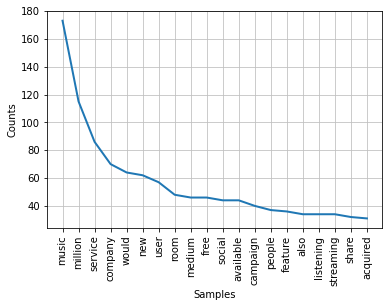

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
all_fdist = FreqDist(all_tokens) #frequent distribution plot#
all_fdist.plot(20,cumulative=False)

In [24]:
print(Text(all_tokens).collocation_list(num=100, window_size=2)) #get 100 most frequent bigram in these websites

[('social', 'medium'), ('million', 'paying'), ('business', 'model'), ('web', 'player'), ('service', 'tier'), ('see', 'fit'), ('marketing', 'campaign'), ('pop', 'culture'), ('closed', 'raising'), ('source', 'income'), ('free', 'service'), ('historically', 'correlated'), ('voice', 'chat'), ('public', 'offering'), ('correlated', 'boost'), ('brand', 'generic'), ('current', 'capacity'), ('decide', 'talk'), ('disclaimer', 'displayed'), ('generic', 'category'), ('largely', 'focus'), ('monetization', 'path'), ('prove', 'vertically'), ('rebrand', 'emphasis'), ('speaker', 'right'), ('traffic', 'prove'), ('digital', 'management'), ('net', 'loss'), ('undisclosed', 'amount'), ('view', 'compilation'), ('major', 'record'), ('sold', 'based'), ('help', 'boost'), ('loss', 'million'), ('per', 'song'), ('album', 'sold'), ('join', 'room'), ('paying', 'million'), ('viral', 'marketing'), ('initial', 'public'), ('went', 'public'), ('activity', 'platform'), ('create', 'edit'), ('past', 'year'), ('platform', 'p

In [25]:
tags = nltk.pos_tag(all_tokens,tagset='universal')
freq = FreqDist([t for w,t in tags])
freq.most_common() #clarify the words POS Tag categories

[('NOUN', 2663),
 ('ADJ', 1046),
 ('VERB', 994),
 ('ADV', 357),
 ('NUM', 227),
 ('ADP', 142),
 ('DET', 27),
 ('PRON', 7),
 ('CONJ', 5),
 ('PRT', 2)]

In [26]:
from itertools import islice

top_20 = [word for word,n in counter.most_common(20)] #get the most frequent 20 words in all pages
print(top_20)

['music', 'million', 'service', 'company', 'would', 'new', 'user', 'room', 'medium', 'free', 'social', 'available', 'campaign', 'people', 'feature', 'also', 'listening', 'streaming', 'share', 'acquired']


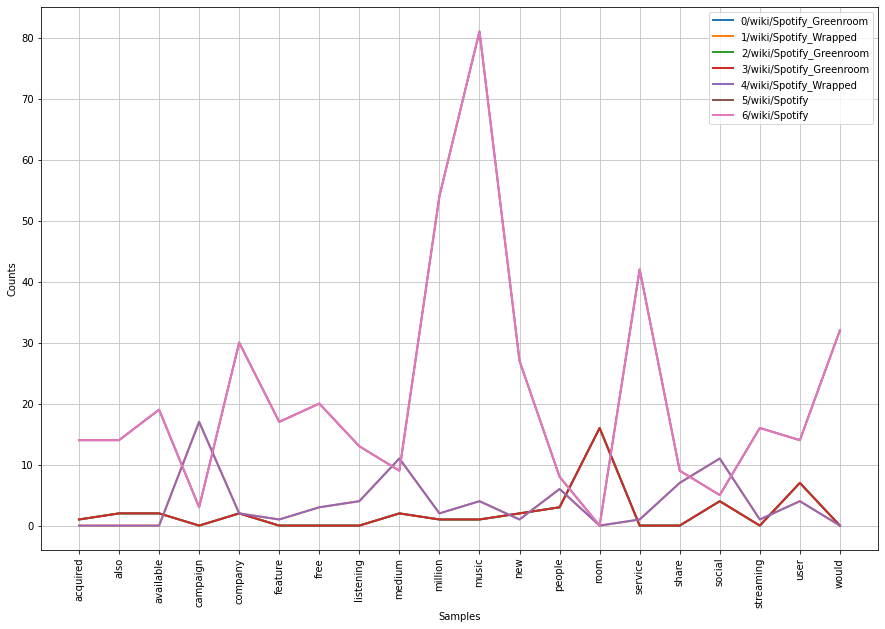

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
#import matplot for enlarging the plot properties
import matplotlib.pyplot as plt

kw_dist = [(k,token) for (k,tokens) in islice(tokens_book.items(), 0, 20) for token in tokens if token in top_20]
plt.figure(figsize=(15, 10))

cfd = nltk.ConditionalFreqDist(kw_dist)
cfd.plot()

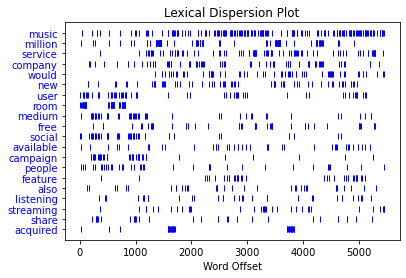

In [29]:
top_20 = [word for word,n in counter.most_common(20)]
%matplotlib inline
Text(all_tokens).dispersion_plot(top_20)
#Draw lexcial dispersion plot# 

In [30]:
for word in top_20:
    print('Words in similar context with {}:\n'.format(word))
    Text(all_tokens).similar(word)
    print('\n')

Words in similar context with acquired:

new


Words in similar context with share:

campaign


Words in similar context with streaming:

restricted annotation


Words in similar context with listening:

number


Words in similar context with also:




Words in similar context with feature:

need


Words in similar context with people:

selected


Words in similar context with campaign:

share retaining


Words in similar context with available:




Words in similar context with social:




Words in similar context with free:




Words in similar context with medium:

service


Words in similar context with room:




Words in similar context with user:

beta


Words in similar context with new:

acquired


Words in similar context with would:




Words in similar context with company:

listen


Words in similar context with service:

medium million grew


Words in similar context with million:

service monthly total revenue major grew value


Words in similar context with music:

well 